<a href="https://colab.research.google.com/github/pseudopunit/NLP/blob/master/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import json
import tweepy as tw
import nltk
from nltk.corpus import stopwords
from nltk import bigrams
import re
from textblob import TextBlob
import networkx
import networkx as nx
# !pip install earthpy
import earthpy as et


import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

# Get the already collected twitter data in JSON format
et.data.get_data('twitter-flood')

# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 1.4MB 4.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 18.2MB 230kB/s 
     |████████████████████████████████| 972kB 43.3MB/s 
     |████████████████████████████████| 10.9MB 42.7MB/s 
     |████████████████████████████████| 14.8MB 152kB/s 
  Created wheel for earthpy: filename=earthpy-0.9.2-cp36-none-any.whl size=1365088 sha256=95935c3f0f08860fc4a28acf573a429cde43b450cdc1d17412e03f83ce63d25e
  Stored in directory: /root/.cache/pip/wheels/27/f9/a5/026bb95ef7b12f9343b842da6897b4001c5b902550095cbbbe
Successfully built earthpy


In [2]:
flood_tweets_path = os.path.join("twitter-flood", "boulder_flood_geolocated_tweets.json")
flood_tweets_path

'twitter-flood/boulder_flood_geolocated_tweets.json'

In [3]:
# Loop through each tweet in the JSON file and append it to a list
flood_tweets = []
for line in open(flood_tweets_path, 'r'):
    flood_tweets.append(json.loads(line))

# View a single tweet in your list.
flood_tweets[1]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Dec 31 18:49:31 +0000 2013',
 'entities': {'hashtags': [{'indices': [108, 113], 'text': 'snow'},
   {'indices': [114, 119], 'text': 'COwx'},
   {'indices': [120, 128], 'text': 'weather'},
   {'indices': [129, 136], 'text': 'Denver'}],
  'symbols': [],
  'urls': [],
  'user_mentions': [{'id': 1214463582,
    'id_str': '1214463582',
    'indices': [0, 14],
    'name': 'WeatherDude',
    'screen_name': 'WeatherDude17'}]},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 418091565161017345,
 'id_str': '418091565161017345',
 'in_reply_to_screen_name': 'WeatherDude17',
 'in_reply_to_status_id': 418091408994471937,
 'in_reply_to_status_id_str': '418091408994471937',
 'in_reply_to_user_id': 1214463582,
 'in_reply_to_user_id_str': '1214463582',
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 0,
 'retweeted': False,
 'source': '<a href="https://about.twitter.com/products/tweetdeck" rel="no

In [4]:
type(flood_tweets[1])

dict

In [5]:
a_single_tweet = flood_tweets[1]
a_single_tweet.keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang'])

In [6]:
# View the created at time stamp in the dictionary
a_single_tweet["created_at"]

'Tue Dec 31 18:49:31 +0000 2013'

In [7]:
a_single_tweet["entities"]["hashtags"]

[{'indices': [108, 113], 'text': 'snow'},
 {'indices': [114, 119], 'text': 'COwx'},
 {'indices': [120, 128], 'text': 'weather'},
 {'indices': [129, 136], 'text': 'Denver'}]

In [8]:
# Get the second item in the list and it's associated hashtag
a_single_tweet["entities"]["hashtags"][1]["text"]

'COwx'

In [10]:
def remove_url_punctuation(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)
    
    punct_pattern = re.compile(r'[^\w\s]')
    no_punct = punct_pattern.sub(r'', no_url)
    
    # Clean up punctuation (including pound signs)
    return no_punct

In [11]:
# Create a custom search term and define the number of tweets
flood_tweets[2]["text"]

'Story of my life! 😂 #boulder http://t.co/ZMfNKEl0xD'

In [12]:
# Remove URLs
tweets_no_urls = [remove_url_punctuation(atweet["text"]) for atweet in flood_tweets]
tweets_no_urls[2]

'Story of my life  boulder '

In [13]:
# Create a list of lists containing lowercase words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in tweets_no_urls]
words_in_tweet[2]

['story', 'of', 'my', 'life', 'boulder']

In [14]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_tweet))

# Count each word across all tweets - notice there are still stop words
counts_no_urls = collections.Counter(all_words_no_urls)
counts_no_urls.most_common(15)

[('rt', 7884),
 ('boulder', 6980),
 ('the', 6849),
 ('in', 5730),
 ('to', 5619),
 ('cowx', 5338),
 ('boulderflood', 5317),
 ('of', 4778),
 ('coflood', 4312),
 ('a', 3240),
 ('for', 3156),
 ('and', 2823),
 ('is', 2596),
 ('at', 2330),
 ('on', 2282)]

In [15]:
# Remove stop words and any other words you want to clean up
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

# Remove collection and other twitter related words (rt = retweet on twitter)
collection_words = ['rt']
tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

tweets_nsw_nc[2]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['story', 'life', 'boulder']

In [16]:
# Process for word counts
all_words_nsw = list(itertools.chain(*tweets_nsw_nc))

counts_nsw = collections.Counter(all_words_nsw)

clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])
clean_tweets_nsw

,words,count
0,boulder,6980
1,cowx,5338
2,boulderflood,5317
3,coflood,4312
4,colorado,2237
5,denver,1480
6,flood,1285
7,snow,1202
8,amp,1202
9,weather,1070


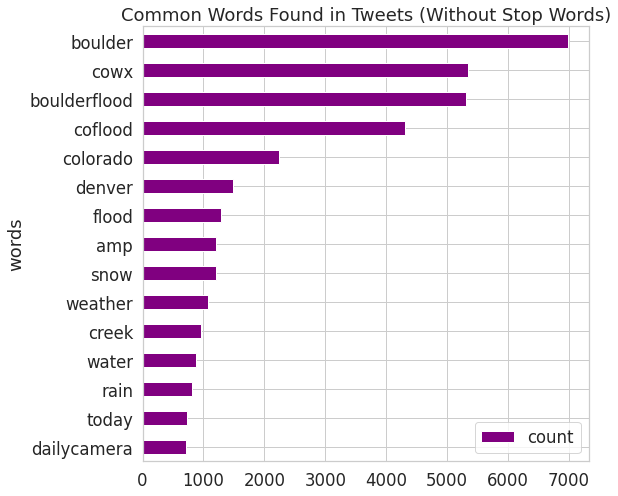

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()

In [18]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in tweets_nsw_nc]

# Flatten list of bigrams in clean tweets
coupled_words = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(coupled_words)

bigram_counts.most_common(20)

[(('cowx', 'weather'), 618),
 (('boulder', 'colorado'), 457),
 (('boulder', 'creek'), 436),
 (('cowx', 'coflood'), 408),
 (('boulderflood', 'cowx'), 287),
 (('boulder', 'county'), 268),
 (('boulderflood', 'coflood'), 256),
 (('cowx', 'gjco'), 214),
 (('boulder', 'boulderflood'), 199),
 (('cowx', 'westernslope'), 192),
 (('cowx', 'denver'), 189),
 (('flash', 'flood'), 188),
 (('boulder', 'canyon'), 185),
 (('coflood', 'cowx'), 181),
 (('wall', 'water'), 179),
 (('coflood', 'boulderflood'), 164),
 (('higher', 'ground'), 163),
 (('dailycamera', 'boulder'), 156),
 (('flood', 'warning'), 149),
 (('boulder', 'co'), 144)]

In [19]:
# Create a network plot of grouped terms
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

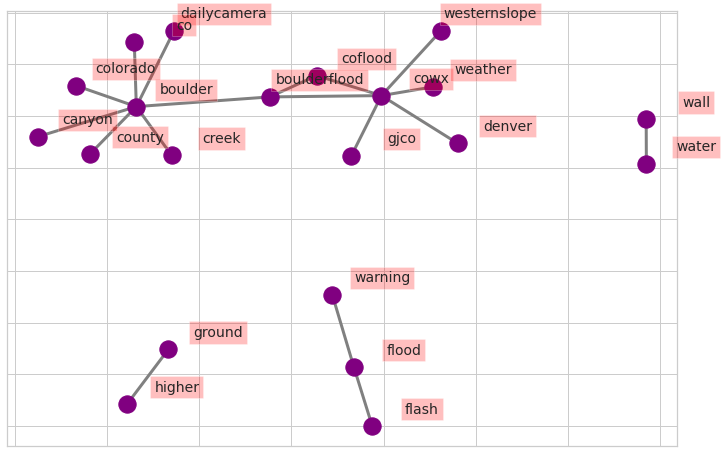

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(G, k=5.5)
# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.05
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=14)
    
plt.show()

In [21]:
# Create textblob objects of the tweets
sentiment_objects = [TextBlob(tweet) for tweet in tweets_no_urls]

sentiment_objects[0].polarity, sentiment_objects[2]

(-0.5, TextBlob("Story of my life  boulder "))

In [22]:
# Create list of polarity values and tweet text
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

sentiment_values[2:8]

[[0.0, 'Story of my life  boulder '],
 [0.0,
  'Were looking for the two who came to help a cyclist after a hitandrun at 30thBaseline 11pm Dec 23rd Boulder CO '],
 [0.3575757575757576,
  'Happy New Year Boulder  What are some of your New Years resolutions this year'],
 [0.34545454545454546,
  'simon_Says_so Nearly 60 degrees in Boulder today Great place to live '],
 [0.0, 'Deer boulder onlyinboulder '],
 [0.0,
  'NWS has only bumped up tomrorows odds for snow in Denver from 30 to 40 To me it feels like it should be closer to 60 COwx weather']]

In [23]:
# Create dataframe containing the polarity value and tweet text
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

sentiment_df.tail()

,polarity,tweet
18816,0.000,RT EricRobertson A more representative flood p...
18817,0.125,Warning Flash flood of boulder creek is immine...
18818,0.550,I just got an Emergency Alert Nice to know the...
18819,0.000,RT dailycamera RT CUBoulderPolice Some floodi...
18820,0.000,monikarun courtneyo eatplaylove Greeblemonkey ...


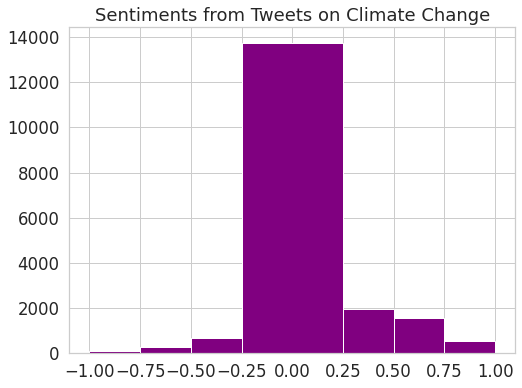

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on Climate Change")
plt.show()

In [25]:
# Remove polarity values equal to zero
sentiment_df = sentiment_df[sentiment_df.polarity != 0]

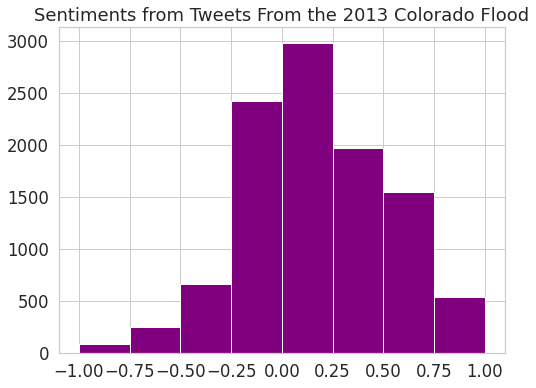

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with break at zero
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets From the 2013 Colorado Flood")
plt.show()